## LS_Lab test

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
from scipy.sparse import csr_matrix
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats
from sklearn.metrics import roc_auc_score, average_precision_score
import xchrom as xc

In [3]:
input_path = '../'
save_path = './Results/'
input_test_mod2 = sc.read_h5ad(f'{input_path}/0_preprocess/processed_data/test_atac.h5ad')  ## cross-samples test label
pred_test = sc.read_h5ad(f'{save_path}/lslab_pred.h5ad')  ## cross-samples test prediction

### test cell auROC&auPRC

In [4]:
pred = pd.DataFrame(data=pred_test.X.todense(),index=pred_test.obs_names,columns=pred_test.var_names)
true = pd.DataFrame(data=input_test_mod2.X.todense(),index=input_test_mod2.obs_names,columns=input_test_mod2.var_names)

In [5]:
print(pred.shape,true.shape)

(4220, 53735) (4220, 53735)


In [6]:
pred = np.array(1 / (1 + np.exp(-np.array(pred))))
true[true > 1] = 1
true = np.array(true)

## -1 Calculate overall auROC & auPRC 
overall_metrics = xc.tl.calc_auc_pr(true, pred, 'overall')
print(f"Overall auROC: {overall_metrics['auroc']:.4f}, auPRC: {overall_metrics['auprc']:.4f}")

## -2 Calculate per cell auRPC & auPRC
cell_metrics = xc.tl.calc_auc_pr(true, pred, 'percell')
print(f"Per-cell auROC: {cell_metrics['auroc']:.4f}, auPRC: {cell_metrics['auprc']:.4f}")
print(f"Valid cells: {cell_metrics['n_cells']}")

## -3 Calculate per peak auROC & auPRC
peak_metrics = xc.tl.calc_auc_pr(true, pred, 'perpeak')
print(f"Per-peak auROC: {peak_metrics['auroc']:.4f}, auPRC: {peak_metrics['auprc']:.4f}")
print(f"Valid peaks: {peak_metrics['n_peaks']}")

Overall auROC: 0.8063, auPRC: 0.1775
Per-cell auROC: 0.8068, auPRC: 0.1679
Valid cells: 4220
Per-peak auROC: 0.6650, auPRC: 0.0796
Valid peaks: 53735


### test cell ns&ls

In [7]:
rna = sc.read_h5ad(f'{input_path}/0_preprocess/processed_data/test_rna.h5ad') ## provide X_pca to compute neighbors
rna = xc.tl.calc_pca(rna,max_value=10,n_comps=32)

/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/home/miaoyuanyuan/miniconda3/envs/py3.8_tf2.6.0/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


neighbor score(100)=0.2647,label score(100)=0.6831
neighbor score(50)=0.1821,label score(50)=0.7134
neighbor score(10)=0.0680,label score(10)=0.7570


<AxesSubplot:title={'center':'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

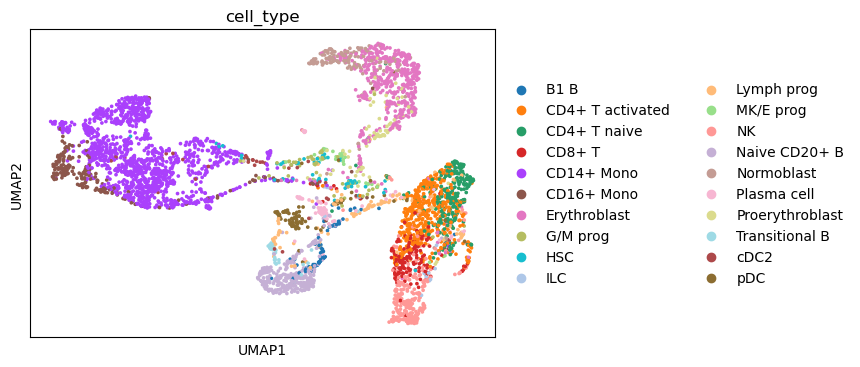

In [8]:
## LS_Lab impute
ad1 = xc.tl.calc_pca(pred_test)
ns,ls= xc.tl.calc_nsls_score(rna,ad1,100,'cell_type',use_rep_rna = 'X_pca',use_rep_atac='X_pca')
print(f'neighbor score(100)={ns:.4f},label score(100)={ls:.4f}')

ns,ls= xc.tl.calc_nsls_score(rna,ad1,50,'cell_type',use_rep_rna = 'X_pca',use_rep_atac='X_pca')
print(f'neighbor score(50)={ns:.4f},label score(50)={ls:.4f}')

ns,ls= xc.tl.calc_nsls_score(rna,ad1,10,'cell_type',use_rep_rna = 'X_pca',use_rep_atac='X_pca')
print(f'neighbor score(10)={ns:.4f},label score(10)={ls:.4f}')

f, ax = plt.subplots(1, 1, figsize=(6, 4))
sc.pl.umap(ad1, color='cell_type', ax=ax, show=False)